# Importing dependencies and all required functions

The cell below imports dependencies from the script files in the folder Import_Scripts

In [1]:
import sys
import os
# Get the path of the directory where the script is located
script_path = os.getcwd()

os.chdir(script_path+'/Import_Scripts')
# The five scripts below contain all the functions used in this and other notebooks
from NIR_ImportExport import *
from NIR_Metrics import *
from NIR_Plots import *
from NIR_Preprocessing import *
from NIR_Training import *
from NIR_Uncertainty import *

os.chdir(script_path)

# Data import from excel file

The cell below imports the required spectral data from an Excel spreadsheet in the main folder. The entire excel file is imported and then segmented into training and testing datasets based on the user defined categorisation in the excel file (example is given in this repository)

In [3]:
file_name="Training_Testing_Data_ModelDevelopment.xlsx" # Imports the training and testing data from the excel file
_, wavelength, spectra_raw=file_import(file_name,'Reflectance') # Extracts the spectral data and the wavelength

training_set = pd.read_excel(file_name, sheet_name="Names",header=0).loc[:,'Training?'].values=="Y" # Gets the indices of the training set
testing_set = pd.read_excel(file_name, sheet_name="Names",header=0).loc[:,'Testing?'].values=="Y" # Gets the indices of the testing set
comp_dataset = pd.read_excel(file_name, sheet_name="Compositions",header=0) ; comp_headers=['Glucan','Hemicellulose','Lignin'] # Gets the compositions
comp_vals=comp_dataset.loc[:,comp_headers].values ; comp_vals_train=comp_vals[training_set] ; comp_vals_test=comp_vals[testing_set] # Segments the compositions into training and testing datasets as defined in the excel file


The following cell shows the distribution of the testing and training data for all 3 components

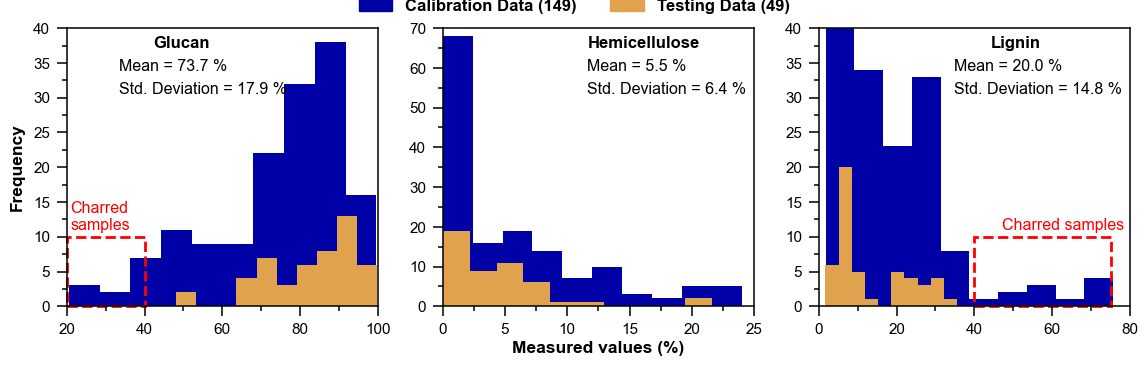

In [ ]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(111, frameon=False)
axes=fig.subplots(1,3)

for i in range(comp_vals_train.shape[1]):
    axes[i].hist(comp_vals_train[:,i], bins=10, color = '#0000a7')
    axes[i].hist(comp_vals_test[:,i], bins=10, color = '#e0a24c')
    axes[i].xaxis.set_minor_locator(AutoMinorLocator(n=2))
    axes[i].yaxis.set_minor_locator(AutoMinorLocator(n=2))
    std = comp_vals_train[:,i].std(axis=0) ; mean = comp_vals_train[:,i].mean(axis=0) 
    axes[i].plot([],[],' ', label = 'Mean = ' + str(round(mean,1)) + ' %') ; axes[i].plot([],[],' ', label = 'Std. Deviation = ' + str(round(std,1)) + ' %')
    axes[i].legend(title=comp_headers[i], title_fontproperties = {'size': 12, 'weight':'bold'},prop = {'size': 11.5})

rect = mpatches.Rectangle( (20,0), 20, 10, edgecolor = 'red', linewidth = 2, linestyle = 'dashed', facecolor = 'None', clip_on=False)
axes[0].add_patch(rect)
axes[0].text(21,11,'Charred\nsamples', horizontalalignment = 'left', color = 'red',fontsize=11.5)

rect = mpatches.Rectangle( (40,0), 35, 10, edgecolor = 'red', linewidth = 2, linestyle = 'dashed', facecolor = 'None', clip_on=False)
axes[2].add_patch(rect)
axes[2].text(47,11,'Charred samples', horizontalalignment = 'left', color = 'red',fontsize=11.5)

patch_1 = mpatches.Patch(color='#0000a7')
patch_2 = mpatches.Patch(color='#e0a24c')
handles, labels = ax.get_legend_handles_labels() ; handles.append(patch_1) ; handles.append(patch_2) ; labels.append('Calibration Data (' + str(comp_vals_train.shape[0])+')') ; labels.append('Testing Data (' + str(comp_vals_test.shape[0])+')')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Measured values (%)', labelpad=25, fontweight="bold")
ax.set_ylabel('Frequency', labelpad=30, fontweight="bold")
fig.tight_layout()
fig.legend(handles,labels, loc = 'upper center', ncol=2, borderpad = -0.55,prop = {'size': 12, 'weight':'bold'})

# plt.savefig('ModelData.png',pad_inches=0,bbox_inches='tight')
plt.show()

# Preprocessing of the data

The cell below averages the spectral data (4 repeats were taken for the data in this repository) but this can be adjusted based on user preference

In [5]:
spectra_raw_avg=spectra_avg(spectra_raw, num_repeats=4) # Averages the spectral data (Assumes 4 repeats)
# The below 3 lines generate a set of dummy preprocessed data to get the number of preprocessing methods done
low_nm_test = 800 ; up_nm_test = 2500
_, X_train_test, _ = preprocessing_combined(low_nm_test, up_nm_test, spectra_raw_avg, wavelength, spectra_raw, training_set, testing_set)
ncomp = len(comp_headers) ; npreproc = X_train_test.shape[2]

(426, 149)
(426, 49)


The wavelength ranges to be used for model development are then defined. These wavelengths *MUST* be multiples of 4 (or the data interval of your collected dataset)

In [6]:
# specifies the wavelength ranges to be investigated (user-defined)
low_nm_range=np.array([800, 948, 1100, 1248, 1400, 1500]) ; up_nm=2500

The methods to be used for model development are then defined. Several options are given in the cell below. The labels and names are also specified for the further steps of saving the results to another excel sheet

In [7]:
# Capability for PLS, PCA and SVR has been included - all_vector defines whether univariate or multivariate models will be developed
# Some more options given in the 2 commented lines - 
# max_n_comp_vec defines the the maximum number of components/SVR value to be studied to - MUST EQUAL n_methods + n_all_vector
methods = ['PLS','PLS']; all_vector = [True, False] ; max_n_comp_vec = [25, 25]
# methods = ['PLS','PLS','PCA','PCA','SVR','Standard-SVR']; all_vector = [True, False, True, False, False, False]
# methods = ['PLS','PLS','PCA','PCA']; n_methods = len(methods) ; all_vector = [True, False, True, False] ; max_n_comp_vec = [25, 25, 25, 25]

# Specification of technique names and preprocessing labels for output in excel file
technique_str = ['PLS Multivariate','PLS Univariate','PCA Multivariate','PCA Univariate']
# technique_str = ['PLS Multivariate','PLS Univariate','PCA Multivariate','PCA Univariate','SVR Univariate','Standard-SVR Univariate']
preprocess_labels=['Raw','SNV','MSC','SNV(Detrend)','1st Derivative','2nd Derivative','Centered', \
    'SG1-SNV','SG1-MSC','SG2-SNV','SG2-MSC']

n_methods = len(methods) 
print("Import complete")

Import complete


# Model Training and Results Saving (can be skipped)

The for loop in the cell below loops over the wavelength ranges and the preprocessing methods to be investigated. The results are then saved to the initially empty numpy array "output_component_wise"

In [ ]:
output_component_wise = np.zeros((ncomp*low_nm_range.shape[0],n_methods*npreproc,16)) # Generates an empty numpy array to hold the results

In [ ]:
for i in range(low_nm_range.shape[0]):
    low_nm = low_nm_range[i] # Gets the wavelength range for this run
    print(f'Running wavelength range {low_nm}-{up_nm}')
    wavelength_red, X_train, X_test = preprocessing_combined(low_nm, up_nm, spectra_raw_avg, wavelength, spectra_raw, training_set, testing_set)

    for j in range(n_methods):
        print(f'Running model method {j+1}/{n_methods}')
        all = all_vector[j]
        output = preprocess (X_train, comp_vals_train, X_test, comp_vals_test, methods[j], all, max_n_comp=max_n_comp_vec[j], plot_progressval=False, plot_response=False, eval_metrics = True, criterion_train='Haaland')
        l1 = list(range(1,16))

        for k in l1:
            output_component_wise[i*ncomp:(i+1)*ncomp, j*npreproc:(j+1)*npreproc, k] = output[k]

        if all:
            output_component_wise[i*ncomp, j*npreproc:(j+1)*npreproc, 0] = output[0]
        else:
            output_component_wise[i*ncomp:(i+1)*ncomp, j*npreproc:(j+1)*npreproc, 0] = output[0]

 The results are then saved to an excel file in the folder "Training_Results". The next few sections will illustrate how these results can be interpreted

In [ ]:
#Specification of file name for saving
filename='Training_Results/CompositionResults_charmodel.xlsx'
writer = pd.ExcelWriter(filename, engine='xlsxwriter')
writer.save()

# Function to save results to excel file
_ = results_excel_export_complete(filename, output_component_wise, preprocess_labels, technique_str, low_nm_range, comp_headers)

# Generation of dummy excel file to release previous file for opening
filename='Training_Results/CompositionReset.xlsx'
writer = pd.ExcelWriter(filename, engine='xlsxwriter')
writer.save()

# Interpreting Model Training and Testing Results

## Data Import

In [8]:
results_name = 'Training_Results/CompositionResults_charmodel.xlsx'
df = pd.read_excel(results_name, sheet_name='rmse_cv_comp',header = 0)
preprocessing_labels = df.keys()[2:13]
wavelength_labels = df.iloc[:,0].values ; wavelength_labels = np.unique(wavelength_labels)[:-1]
pls_multivar = df.loc[0] == 'PLS Multivariate' ; species_labels = df.iloc[:,1].values ; species_labels = species_labels[1:4]

The cross-validation and testing (validation) root mean squared errors are imported from the excel file first. These are normalised by the standard deviation of the training dataset to help create a single metric to easily compare between different preprocessing methods and wavelength ranges

In [9]:
# Cross Validation
df = df.loc[:,pls_multivar]
rmse_cv_values = df.iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values
glucan_cv = rmse_cv_values[0::3,:] ; hemicellulose_cv = rmse_cv_values[1::3,:] ; lignin_cv = rmse_cv_values[2::3,:]

normalisation = comp_vals_train.std(axis=0)
rmse_cv_norm_ind = np.stack((glucan_cv/normalisation[0], hemicellulose_cv/normalisation[1], lignin_cv/normalisation[2]),axis=2)
rmse_cv_norm = rmse_cv_norm_ind.sum(axis=2)

In [10]:
# Testing (Validation)
df_2 = pd.read_excel(results_name, sheet_name='rmse_val_comp',header = 0)
df_2 = df_2.loc[:,pls_multivar]
rmse_val_values = df_2.iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values
glucan_val = rmse_val_values[0::3,:] ; hemicellulose_val = rmse_val_values[1::3,:] ; lignin_val = rmse_val_values[2::3,:]

rmse_val_norm_ind = np.stack((glucan_val/normalisation[0], hemicellulose_val/normalisation[1], lignin_val/normalisation[2]),axis=2)
rmse_val_norm = rmse_val_norm_ind.sum(axis=2)

Based on the lowest normalised total testing error, the individual cross-validation and tested errors are broken down for each wavelength range

In [11]:
cv_min_arg = np.argmin(rmse_val_norm,axis=1)
for wavelength_ind,preprocessing_ind in enumerate(cv_min_arg):
    print(f'Lower Wavelength: {wavelength_labels[wavelength_ind]} ; Preprocessing method: {preprocess_labels[preprocessing_ind]}')
    print(f'Overall cross-validation error {round(rmse_cv_norm[wavelength_ind,preprocessing_ind],2)} ; Overall testing error {round(rmse_val_norm[wavelength_ind,preprocessing_ind],2)}')
    cv_array = [] ; test_array = []
    for j in range(3):
        cv_array.append(round(rmse_cv_values[3*wavelength_ind+j, preprocessing_ind],1))
        test_array.append(round(rmse_val_values[3*wavelength_ind+j, preprocessing_ind],1))
    print(f'Individual cross-validation errors: {cv_array}')
    print(f'Individual testing errors: {test_array}')

Lower Wavelength: 800.0 ; Preprocessing method: Raw
Overall cross-validation error 1.21 ; Overall testing error 0.73
Individual cross-validation errors: [6.8, 3.4, 4.3]
Individual testing errors: [4.2, 1.7, 3.3]
Lower Wavelength: 948.0 ; Preprocessing method: Centered
Overall cross-validation error 1.13 ; Overall testing error 0.78
Individual cross-validation errors: [6.6, 3.1, 4.0]
Individual testing errors: [4.0, 2.0, 3.7]
Lower Wavelength: 1100.0 ; Preprocessing method: 1st Derivative
Overall cross-validation error 1.18 ; Overall testing error 0.89
Individual cross-validation errors: [6.9, 3.2, 4.4]
Individual testing errors: [4.3, 2.5, 3.8]
Lower Wavelength: 1248.0 ; Preprocessing method: Centered
Overall cross-validation error 1.18 ; Overall testing error 0.92
Individual cross-validation errors: [6.6, 3.3, 4.3]
Individual testing errors: [4.1, 2.6, 4.2]
Lower Wavelength: 1400.0 ; Preprocessing method: SG1-SNV
Overall cross-validation error 1.26 ; Overall testing error 0.89
Individ

The mean absolute errors for each preprocessing and wavelength combination are also extracted from the excel sheet

In [12]:
mae_cv_values = pd.read_excel(results_name, sheet_name='mae_cv',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values
mae_val_values = pd.read_excel(results_name, sheet_name='mae_val',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values

The mode of the error distribution

In [13]:
mode_error_cv_values = pd.read_excel(results_name, sheet_name='mode_error_cv',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values
mode_error_val_values = pd.read_excel(results_name, sheet_name='mode_error_val',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values

The standard deviation of the error distribution

In [14]:
std_error_cv_values = pd.read_excel(results_name, sheet_name='std_error_cv',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values
std_error_val_values = pd.read_excel(results_name, sheet_name='std_error_val',header = 0).loc[:,pls_multivar].iloc[1:species_labels.shape[0]*wavelength_labels.shape[0]+1,:].values

## Plotting of Results

The following cell maps the normalised errors. Certain datasets can be highlighted (up to 5)

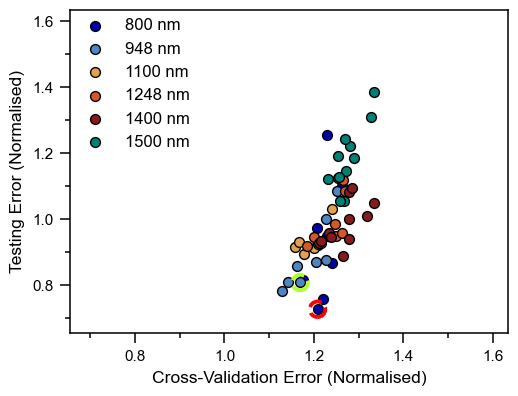

In [15]:
datasets_highlight = ['SNV','Raw'] ; wavelengths_highlight = [948, 800]

normalised_error_plots(rmse_cv_norm, rmse_val_norm, preprocess_labels, wavelength_labels, datasets_highlight, wavelengths_highlight, save = True, save_name = 'Training_Results/Figures/Normalised_Error_Plots')

The following cells maps the errors for each component. Certain datasets can be highlighted (up to 5)

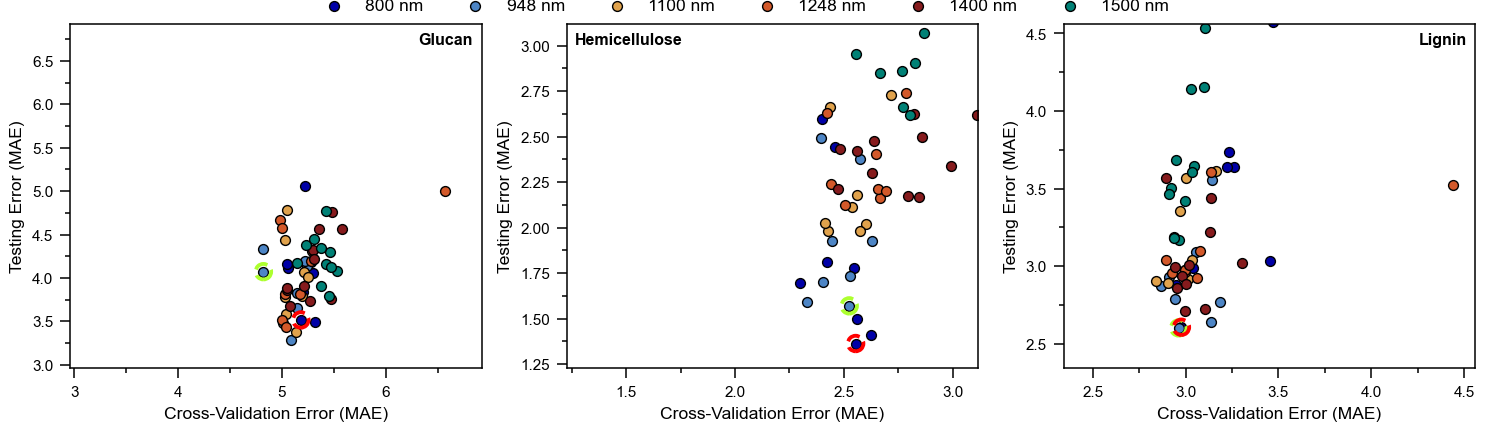

In [16]:
component_error_plots(mae_cv_values, mae_val_values, preprocess_labels, wavelength_labels, datasets_highlight, wavelengths_highlight, species_labels, xlabel = 'Cross-Validation Error (MAE)', ylabel='Testing Error (MAE)', save=True, save_name='Training_Results/Figures/MAE_Error_Plots')

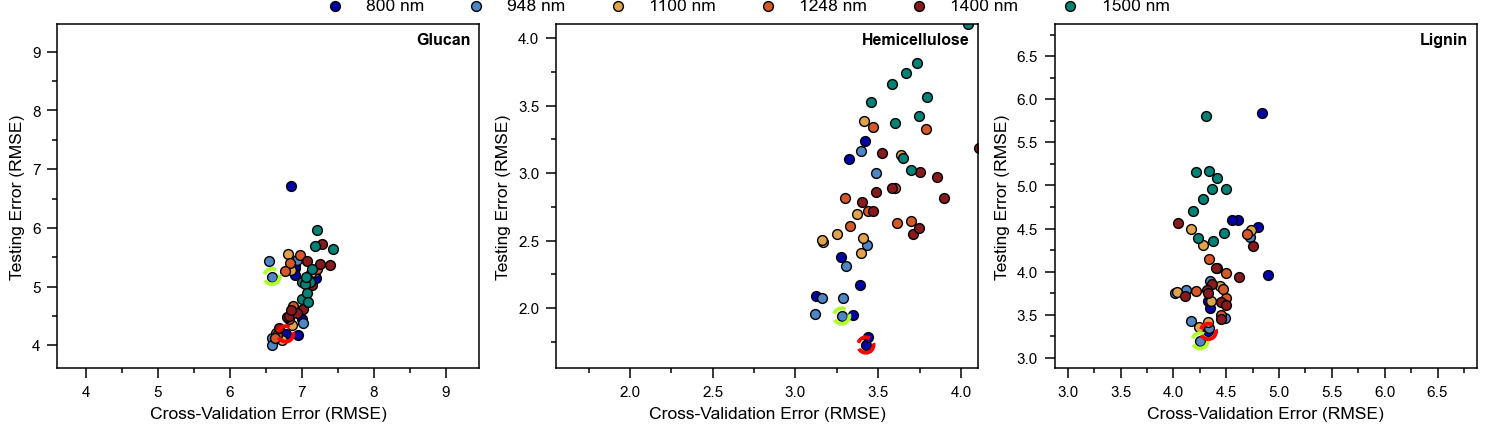

In [17]:
component_error_plots(rmse_cv_values, rmse_val_values, preprocess_labels, wavelength_labels, datasets_highlight, wavelengths_highlight, species_labels, xlabel = 'Cross-Validation Error (RMSE)', ylabel='Testing Error (RMSE)', save=True, save_name='Training_Results/Figures/RMSE_Error_Plots')

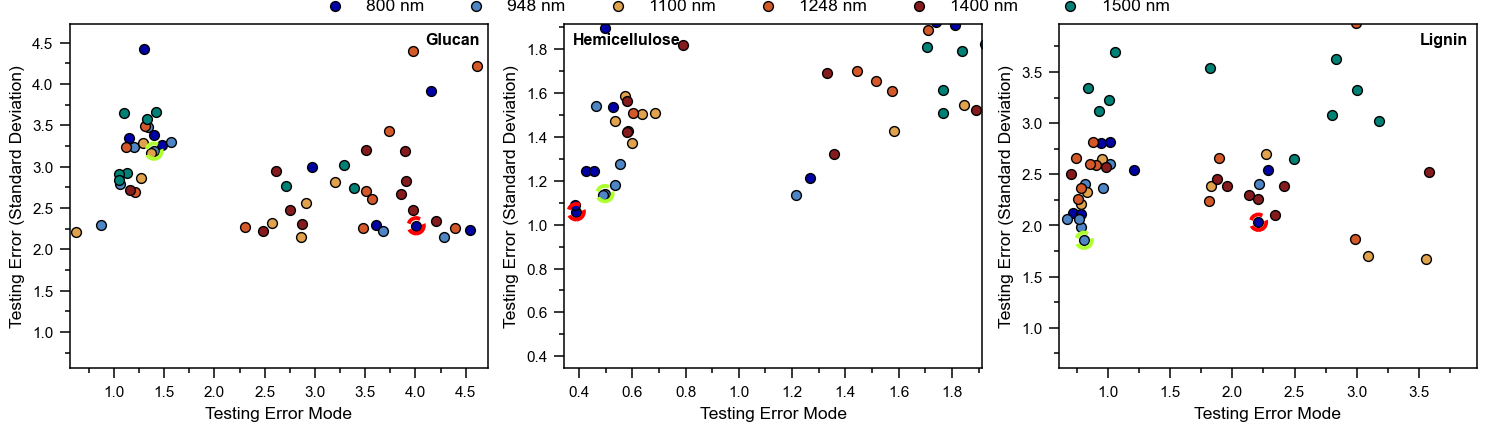

In [18]:
component_error_plots(mode_error_val_values, std_error_val_values, preprocess_labels, wavelength_labels, datasets_highlight, wavelengths_highlight, species_labels, xlabel = 'Testing Error Mode', ylabel='Testing Error (Standard Deviation)', save=True, save_name='Training_Results/Figures/Mode_Error_Plots')

The above plots should help choose the most appropriate model. In this case it is SNV preprocessing with a lower wavelength limit of 948 nm

The following notebook (ModelUncertainty_Notebook.ipynb) will show how this optimally chosen model can be exploited to estimate the prediction uncertainty and then tested on different types of samples to understand the strengths and limitations of the model